# Focus stacking and depth reconstruction

Given a sequence of camera images with different parts in focus, we are able to selectively pick only those areas of an image that are in focus. Likewise, by combining knowledge about the focal distance in each image (e.g. a priori knowledge or from read from EXIF information) we can assemble a depth image.

In [2]:
import os
from typing import *
from PIL import Image, ImageFilter, ImageOps
import skimage
import numpy as np
import glob

Using images such that axes are fixed.

In [39]:
tomo_pics = glob.glob("images/mystery_same_axis_trimmed/hanning/*png")

In [40]:
image_sets = {
    'test_1': tomo_pics
}

In [41]:
PREVIEW_SIZE = (640, 480)

In [42]:
def open_image(image: str, size: Optional[Tuple[int, int]] = None) -> Image.Image:
    path = os.path.join(image)
    im = Image.open(path)
    if size is not None:
        im.thumbnail(size, Image.ANTIALIAS)
    return im

Let's see the first image of a the sequence `test_1`:

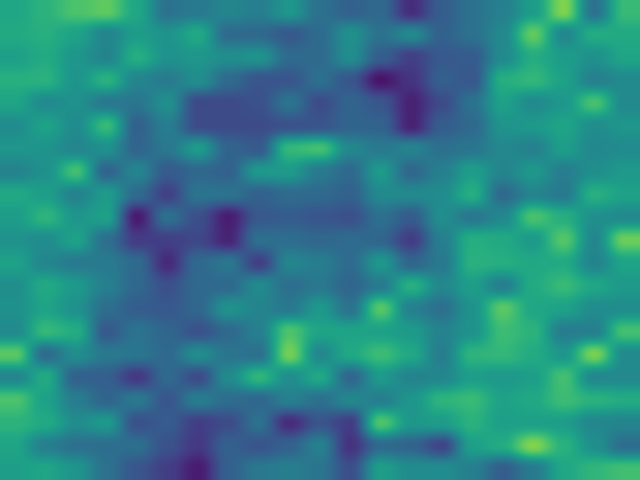

In [43]:
open_image(image_sets['test_1'][0], PREVIEW_SIZE)

We can see that the back of the bracelet is in focus, while the front is out of focus. Here's the last image of `test_1`:

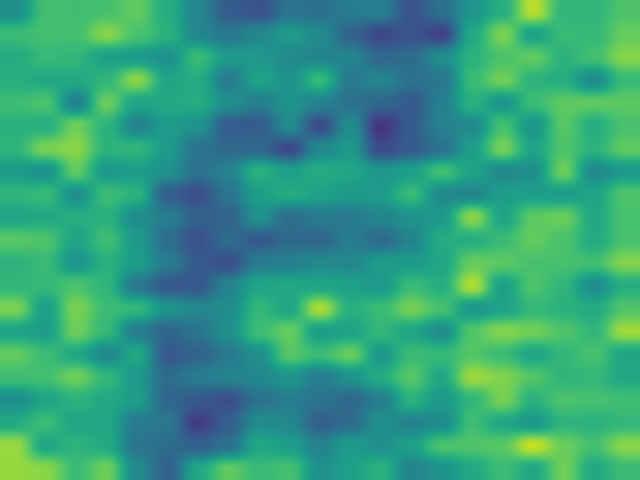

In [44]:
open_image(image_sets['test_1'][-1], PREVIEW_SIZE)

Quite the opposite, this image shows the front in focus while the back is out of focus.

In [45]:
def normalize(arr: np.ndarray) -> np.ndarray:
    min_, max_ = arr.min(), arr.max()
    return (arr - min_) / (max_ - min_)

def to_array(im: Image.Image) -> np.ndarray:
    return np.array(im, dtype=np.float32) / 255.

def to_image(arr: np.ndarray, normalize_image: bool = True) -> Image.Image:
    arr = normalize(arr) if normalize_image else arr
    return Image.fromarray((arr * 255.).astype(np.uint8))    

## Open a dataset

In [46]:
def open_dataset(name: str, size: Optional[Tuple[int, int]] = PREVIEW_SIZE) -> List[Image.Image]:
    return [open_image(pth, size) for pth in image_sets[name]]

imgs_test_1 = open_dataset('test_1')

## Grayscale conversion

For detection of focused areas, the color likely has no influence. To keep things simple, we're going to convert the color images to grayscale images first.
Some conversion methods are discussed in [Color-to-Grayscale: Does the Method Matter in Image Recognition?](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0029740) (Kanan & Kottrell, 2012).

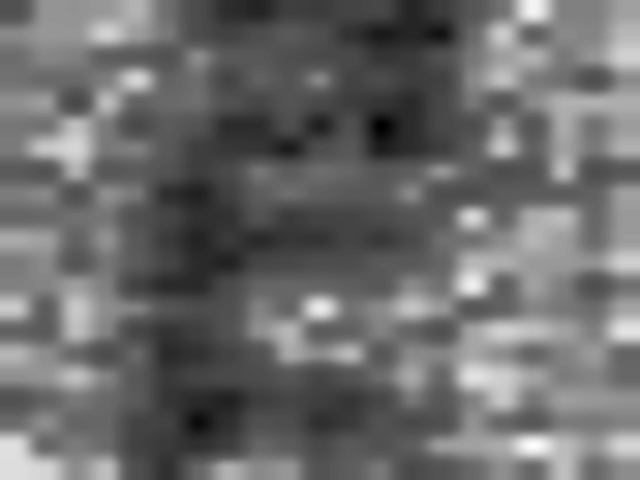

In [47]:
def grayscale_intensity(im: Image.Image) -> Image.Image:
    g = to_array(im).mean(axis=2)
    return to_image(g)

grayscale_intensity(imgs_test_1[-1])

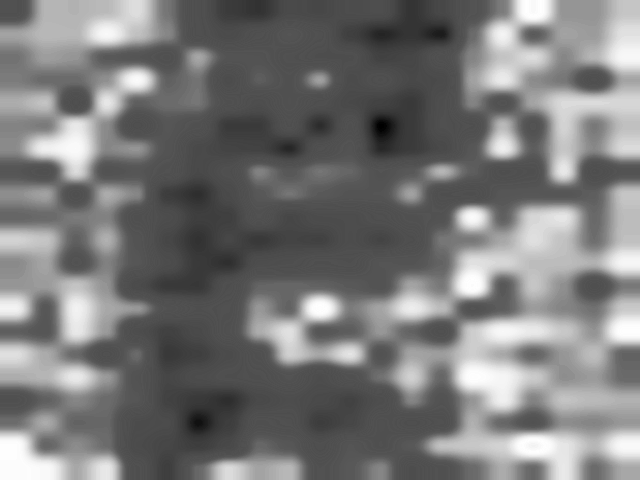

In [48]:
def grayscale_gleam(im: Image.Image) -> Image.Image:
    g = np.power(to_array(im), 1/2.2).mean(axis=2)
    return to_image(g)

grayscale_gleam(imgs_test_1[-1])

## Energy detection

Since (local) energy can be understood as the rate of change of the pixel intensities, we can obtain an energy measure by means of gradients: The more "edges" we find, the higher the (local) energy; the fewer edges, the less. Since out-of-focus areas are blurred, they will contain less energy and should be easy to detect.

In [49]:
from skimage import filters

def laplace(arr: np.ndarray, kernel_size=3, square: bool = False) -> np.ndarray:
    gradients = filters.laplace(arr, kernel_size)
    return gradients * gradients if square else gradients

Here's the local energy map of the back-focused image:

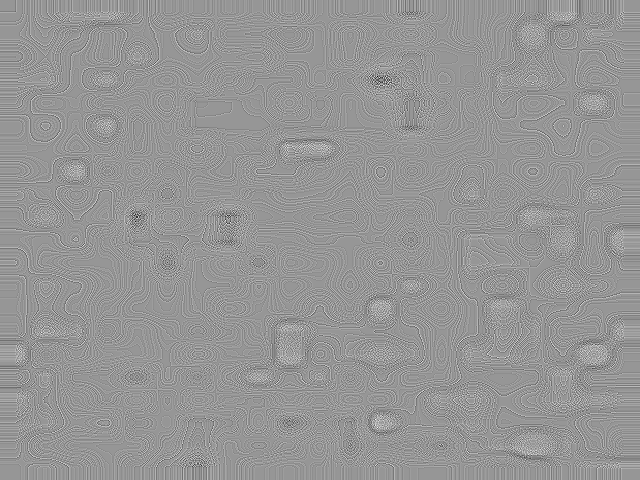

In [50]:
to_image(laplace(to_array(grayscale_gleam(imgs_test_1[0])), 3))

Here's the front-focused image again:

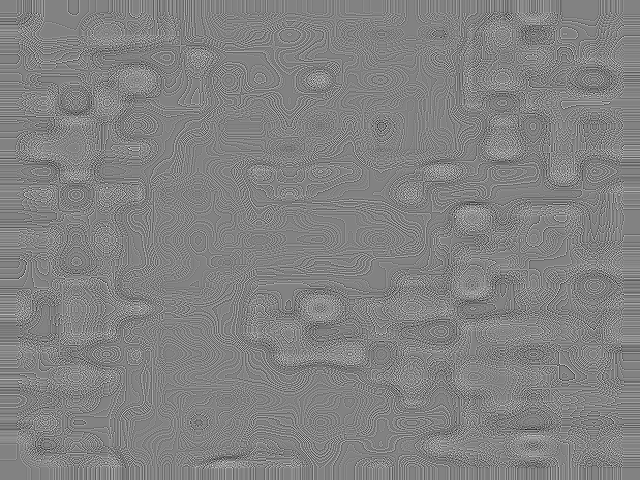

In [51]:
to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3))

We can clearly see how the gradients are more prominent in the specific focus regions.

Since gradients are signed, we'll instead be looking at squared gradients. A result of this is that the minimum local energy is zero (i.e. total absence of any gradient), giving the image an appearance of being black in most places.

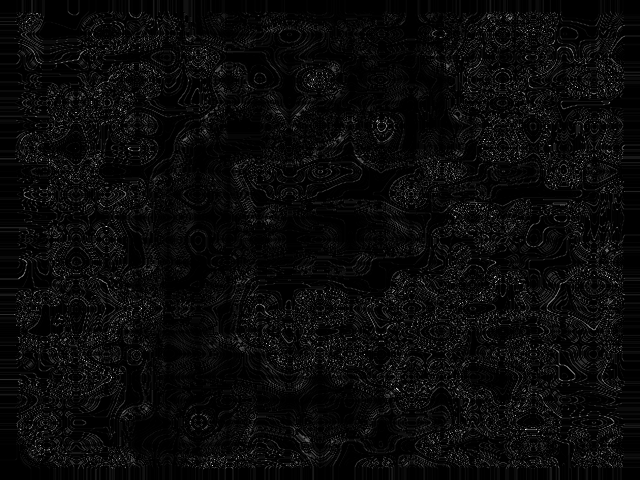

In [52]:
to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3, square=True))

The shape gets clearer when we take the square root of the squared gradients again:

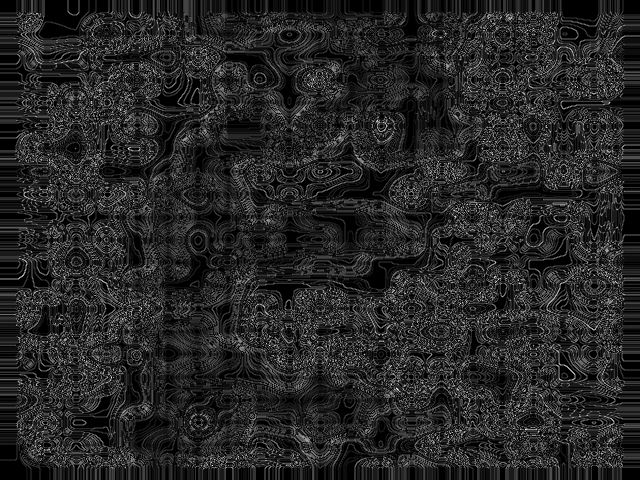

In [53]:
to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3, square=True) ** 0.5)

Since the power function (e.g. taking the square) is monotonic, this isn't strictly necessary during processing.

## Stacking in-focus pixels

When sythesizing (fusing) the focus-stacked image, we're going to select the image with the highest local energy for each pixel. By combining the individual energy images, we can take advantage of NumPy's `argmax` function.

In [54]:
arrs_test_1 = [to_array(grayscale_gleam(img)) 
               for img in imgs_test_1]

In [55]:
energies_test_1 = np.stack([laplace(arr, 3, square=True) for arr in arrs_test_1], axis=2)
energies_test_1.shape

(480, 640, 17)

This allows us to get the index of the best-matching energy image per pixel like so:

In [56]:
highest_energies_idx = np.argmax(energies_test_1, axis=2)
highest_energies_idx

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We can now use this information to pick the correct pixels. First we need the images we're sampling from as an array, so that we can can index the pixels easily:

In [57]:
source = np.stack(arrs_test_1, axis=0)
source.shape

(17, 480, 640)

We can now synthesize an image by sampling from each layer according to it's highest energy.

In [58]:
fused_array = np.zeros(energies_test_1.shape[0:2], dtype=np.float32)
rows, cols = fused_array.shape
for row in range(rows):
    for col in range(cols):
        idx = highest_energies_idx[row, col]
        fused_array[row, col] = source[idx, row, col]

This is how it looks:

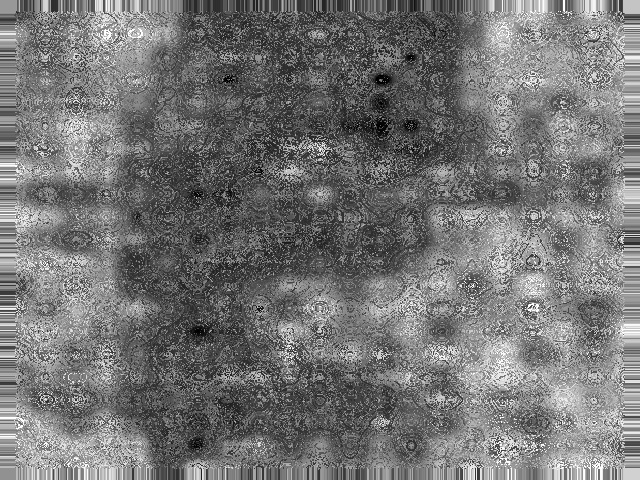

In [59]:
to_image(fused_array)

We can do the same with a color image:

In [60]:
source_color = np.stack(imgs_test_1, axis=0)
source_color.shape

(17, 480, 640, 4)

In [61]:
height, width = energies_test_1.shape[0:2]
fused_array_color = np.zeros((height, width, 3), dtype=np.float32)
rows, cols = fused_array.shape

for row in range(rows):
    for col in range(cols):
        idx = highest_energies_idx[row, col]
        #print(source_color[idx, row, col, :])
        fused_array_color[row, col, :] = source_color[idx, row, col, :][:-3]

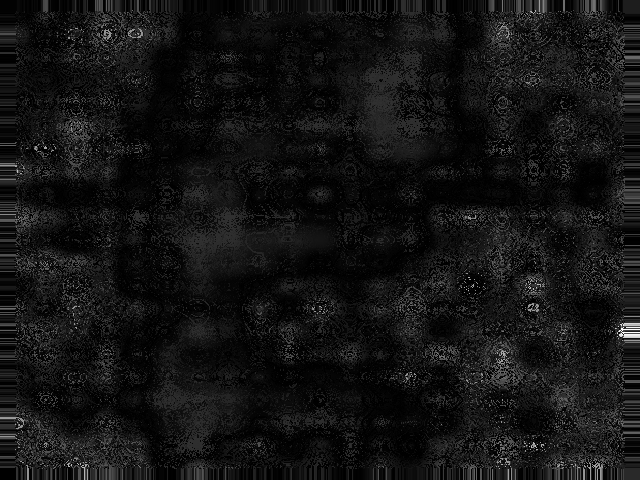

In [62]:
to_image(fused_array_color)

Although the whole image now appears to be in focus, the color image makes sampling artifacts much more visible. Multiple problems are at play:

- Due to movement of the camera, each image might show a slightly area of the object
- The image magnification might be different between different focal lengths
- Noise in the image introduces gradients that do not belong to the object.

## Depth from focus

Rather than synthesizing an in-focus image, we can also do the opposite and synthesize a depth image. Indeed we're already halfway there: We know that the images are already sorted according to their focal length. If they weren't, we would have to take additional information into account, such as EXIF information stored in the image.

Because the images are sorted, the layer index we picked using `argmax` already encodes a depth, albeit not a (physically) meaningful one. Let's visualize that.

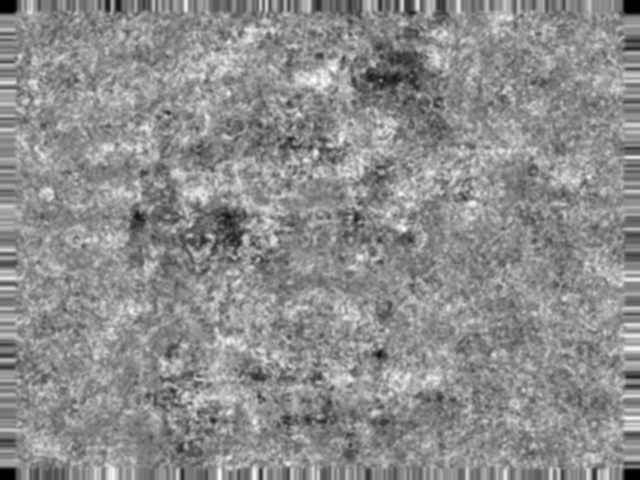

In [63]:
normalized_indexes = normalize(highest_energies_idx)

# We slightly blur the image to not get too distracted by noise.
normalized_indexes_blurred = skimage.filters.gaussian(normalized_indexes, 1.4)
to_image(normalized_indexes_blurred)

As it turns out, this representation is far from perfect:

- Items that are clearly in the background (i.e. the top of the example image) are white and thus appear to be in the foreground, while
- items that are clearly in the foreground (e.g. the pearl) are dark and thus appear to be in the background.

The reason here is that areas without sufficient texture don't have any strong energy regardless of their distance. While this doesn't have a big effect on the pixel color, it does effect the depth synthesis. Likewise, noise creates an appearance of energy where there is none in the actual object, resulting in background items to be sampled.

# Automation Script

In [190]:
import os
from typing import *
from PIL import Image, ImageFilter, ImageOps
from skimage import filters
import numpy as np
import glob


#function definitions
def open_image(image: str,
               size: Optional[Tuple[int, int]] = None) -> Image.Image:
    path = os.path.join(image)
    im = Image.open(path)
    if size is not None:
        im.thumbnail(size, Image.ANTIALIAS)
    return im

def normalize(arr: np.ndarray) -> np.ndarray:
    min_, max_ = arr.min(), arr.max()
    return (arr - min_) / (max_ - min_)


def to_array(im: Image.Image) -> np.ndarray:
    return np.array(im, dtype=np.float32) / 255.


def to_image(arr: np.ndarray, normalize_image: bool = True) -> Image.Image:
    arr = normalize(arr) if normalize_image else arr
    return Image.fromarray((arr * 255.).astype(np.uint8))


def open_dataset(
        name: str,
        size: Optional[Tuple[int, int]] = PREVIEW_SIZE) -> List[Image.Image]:
    return [open_image(pth, size) for pth in image_sets[name]]

def grayscale_intensity(im: Image.Image) -> Image.Image:
    g = to_array(im).mean(axis=2)
    return to_image(g)

def grayscale_gleam(im: Image.Image) -> Image.Image:
    g = np.power(to_array(im), 1 / 2.2).mean(axis=2)
    return to_image(g)

def laplace(arr: np.ndarray,
            kernel_size=3,
            square: bool = False) -> np.ndarray:
    gradients = filters.laplace(arr, kernel_size)
    return gradients * gradients if square else gradients

#main

"""
interps = ["none","nearest", "bilinear", "bicubic", "spline16",
           "spline36", "hanning", "hamming", "hermite", "kaiser", "quadric",
           "catrom", "gaussian", "bessel", "mitchell", "sinc", "lanczos"]

fileNames = ["lead_bricks","lead_brick_gaps" ]
"""

interp = "lanczos"

folder = "lead_bricks"
im_objs = []
tomo_pics = glob.glob("images/{}/{}/*png".format(folder, interp))
image_sets = {'test_1': tomo_pics}
PREVIEW_SIZE = (640, 480)

imgs_test_1 = open_dataset('test_1')
print(imgs_test_1)


im_objs.append(grayscale_intensity(imgs_test_1[-1]))
im_objs.append(grayscale_gleam(imgs_test_1[-1]))

im_objs.append(to_image(laplace(to_array(grayscale_gleam(imgs_test_1[0])), 3)))
im_objs.append(to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3)))
im_objs.append(to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3, square=True)))
im_objs.append(to_image(laplace(to_array(grayscale_gleam(imgs_test_1[-1])), 3, square=True)**0.5))

arrs_test_1 = [to_array(grayscale_gleam(img)) for img in imgs_test_1]

energies_test_1 = np.stack(
    [laplace(arr, 3, square=True) for arr in arrs_test_1], axis=2)

#energies_test_1.shape

highest_energies_idx = np.argmax(energies_test_1, axis=2)
#highest_energies_idx

source = np.stack(arrs_test_1, axis=0)
#source.shape

fused_array = np.zeros(energies_test_1.shape[0:2], dtype=np.float32)
rows, cols = fused_array.shape
for row in range(rows):
    for col in range(cols):
        idx = highest_energies_idx[row, col]
        fused_array[row, col] = source[idx, row, col]

im_objs.append(to_image(fused_array))

source_color = np.stack(imgs_test_1, axis=0)
#source_color.shape

height, width = energies_test_1.shape[0:2]
fused_array_color = np.zeros((height, width, 3), dtype=np.float32)
rows, cols = fused_array.shape

for row in range(rows):
    for col in range(cols):
        idx = highest_energies_idx[row, col]
        #print(source_color[idx, row, col, :])
        fused_array_color[row, col, :] = source_color[idx, row, col, :][:-3]

im_objs.append(to_image(fused_array_color))

normalized_indexes = normalize(highest_energies_idx)

normalized_indexes_blurred = skimage.filters.gaussian(normalized_indexes, 1.4)
im_objs.append(to_image(normalized_indexes_blurred))

im_objs[0].save("result/{}/{}.pdf".format(folder, interp), save_all=True, append_images=im)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F088310>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33EAF1280>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB32EF1D820>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB32EF1DA00>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33ED70C70>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33ED70A60>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E18B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E1670>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E1370>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E1700>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E1F40>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FB33F3E1430>, <PIL.PngImagePl